In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer,root_mean_squared_error, r2_score
import xgboost as xgb

In [3]:
# Import dataset
train_path = "./data/train.csv"
df = pd.read_csv(train_path)
target = 'SalePrice'
X, Y = df.drop(labels=[target], axis=1), np.log(df[target])

(array([ 2.,  3., 14., 44., 98., 66., 42., 17.,  3.,  3.]),
 array([10.47194981, 10.77820213, 11.08445445, 11.39070677, 11.6969591 ,
        12.00321142, 12.30946374, 12.61571606, 12.92196838, 13.22822071,
        13.53447303]),
 <BarContainer object of 10 artists>)

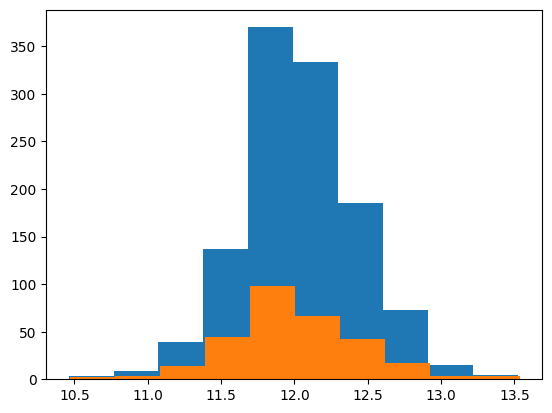

In [4]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
plt.hist(y_train)
plt.hist(y_test)

In [5]:
# Encode categorical variables --> numerical
categorical_vars = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
]

In [6]:
# Gradient Boosting
# Smaller model --> use XGBoost over Light GBM (speed is not a concern)

pipeline = Pipeline([
    ('encoder', ColumnTransformer([
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                    unknown_value=-1), 
        categorical_vars)
    ], remainder='passthrough')),
    
    ('xgb', xgb.XGBRegressor(
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

print("\nMetrics:")
print(f"Train RMSE: {np.sqrt(np.mean((y_train - train_preds) ** 2)):.4f}")
print(f"Test RMSE: {np.sqrt(np.mean((y_test - test_preds) ** 2)):.4f}")


Metrics:
Train RMSE: 0.0035
Test RMSE: 0.1495


In [13]:
# Grid search
param_grid = {
    'xgb__learning_rate': [0.01, 0.005, 0.02],
    'xgb__max_depth': [3],
    'xgb__n_estimators': [1000,3000,5000],
    'xgb__gamma': [0],
    'xgb__lambda': [1],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(root_mean_squared_error),
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X, Y)

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['MSSubClass',
                                                                          'MSZoning',
                                                                          'Street',
                                                                          'Alley',
                                                                          'LotShape',
                                                                          'LandContour',
                                                                          'Utilities',
                                                                          'LotConfig',
                                                                          'LandSlope',
                                                                          'Neighborhood',
                                                                          'Condition1',
                                                                          'Condition2',
                                                                          'BldgType',
                                                                          'Hous...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=3000,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0], 'xgb__lambda': [1],
                         'xgb__learning_rate': [0.01, 0.005, 0.02],
                         'xgb__max_depth': [3],
                         'xgb__n_estimators': [1000, 3000, 5000]},
             return_train_score=True,
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [14]:
results = pd.DataFrame(grid_search.cv_results_['params'])
results.columns = [col.replace('xgb__', '') for col in results.columns]
results['train_rmse'] = grid_search.cv_results_['mean_train_score']
results['test_rmse'] = grid_search.cv_results_['mean_test_score']
results = results.sort_values('test_rmse')

results

,gamma,lambda,learning_rate,max_depth,n_estimators,train_rmse,test_rmse
5,0,1,0.005,3,5000,0.058518,0.125427
6,0,1,0.020,3,1000,0.064104,0.125611
1,0,1,0.010,3,3000,0.053624,0.125629
4,0,1,0.005,3,3000,0.071363,0.125801
2,0,1,0.010,3,5000,0.039125,0.126008
7,0,1,0.020,3,3000,0.034059,0.126444
8,0,1,0.020,3,5000,0.019856,0.126843
0,0,1,0.010,3,1000,0.081641,0.127707
3,0,1,0.005,3,1000,0.101192,0.136330


In [15]:
# Final predictions
test_path = './data/test.csv'
test_df = pd.read_csv(test_path)


final_params = {
    'xgb__learning_rate': 0.005,
    'xgb__max_depth': 3,
    'xgb__n_estimators': 5000,
    'xgb__gamma': 0,
    'xgb__lambda': 1
    }

pipeline.set_params(**final_params)
pipeline.fit(X, Y)

final_predictions = pipeline.predict(test_df)

# Save into df and csv
test_df['SalePrice'] = np.exp(final_predictions)
test_df[['Id', 'SalePrice']].to_csv('results.csv', index=False)